# Prediction of Transcription Factories: A Machine Learning Blueprint
### Shaurya Jauhari, Mora Lab, GZHMU.

Transcription Factories are those purported sites that have been identified as the breeding grounds for transcripts. Their relevance heightens when the spatial organization of the genome is considered. Since transcription factories attract distant segments of the genome together for inter-mingling and possibly carrying out regulation, true picture emerges of the parts that co-localize and co-express. This has been a major lacuna in the dogma of the current suite of enrichment tools for genomic regions.

## Prerequisites

The protocol would require the availability of the following tools. Kindly ensure that they have been successfully installed in your system and embrace a **PATH** variable definition.
1. [samtools](http://www.htslib.org/)
2. [deeptools](https://deeptools.readthedocs.io/en/develop/)

Additionally, the notebook employs several bash scripts that are available [here](https://github.com/shauryajauhari/transcriptionFactoriesGREG/tree/master/terminalScripts). These scripts hold the relevant annotation.

## Setting up Data

We have compiled a tabulation for the metadata associated with cell types in GREG. The relevant features shall be the basis for our machine learning model, but before even reaching that far we're tempted to visualize the reads from these features (transcription factors, histone marks, and RNA-Seqs).

In [2]:
## Install package to read excel file and load library.
install.packages("readxl")
library(readxl)
  
## Import the master table.
masterData <- read_excel("siftedData.xlsx")

## Identifying individual download links for the features
masterData$`Download Link` <- strsplit(masterData$`Download Link`, ",")

## For consistency and cleanliness, let's remove whitespaces from the column.
  for (i in 1: nrow(masterData))
  {
    for (j in 1: length(masterData$`Download Link`[[i]]))
    {
     lapply(masterData$`Download Link`[[i]][j], trimws)
    }
  }

head(masterData)

Cell Type,Feature,Samples,Source,Species,Genome Version,Laboratory,Notes,Download Link,File Type,Selection Criteria
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>,<chr>,<chr>
A549,CTCF,GSM1003582,ENCODE,Homo sapiens,hg19,"Bradley Bernstein, Broad","GSM1003582 is from Bradley Bernstein, Broad and the sample is treated with 100 nM dexamethasone for 1 hour","https://www.encodeproject.org/files/ENCFF631JUR/@@download/ENCFF631JUR.bam , https://www.encodeproject.org/files/ENCFF685FVQ/@@download/ENCFF685FVQ.bam",BAM,More samples from this lab; more chosen samples from this method (treatment with 100 nM dexamethasone for 1 hour).
A549,EP300,GSM1010827,ENCODE,Homo sapiens,hg19,"Myers Lab, Hudson Alpha Institute of Biotechnology.",GSM1010827 is treated with 0.02% ethanol for 1 hour,"https://www.encodeproject.org/files/ENCFF540LLB/@@download/ENCFF540LLB.bam , https://www.encodeproject.org/files/ENCFF864VSA/@@download/ENCFF864VSA.bam",BAM,Only choice
A549,H3K27me3,GSM1003577,ENCODE,Homo sapiens,hg19,"Bradley Bernstein, Broad","GSM1003577 is from Bradley Bernstein, Broad and the sample is treated with 100 nM dexamethasone for 1 hour","https://www.encodeproject.org/files/ENCFF800NPS/@@download/ENCFF800NPS.bam , https://www.encodeproject.org/files/ENCFF664RTA/@@download/ENCFF664RTA.bam",BAM,More chosen samples from this method (treatment with 100 nM dexamethasone for 1 hour)
A549,H3K36me3,GSM1003494,ENCODE,Homo sapiens,hg19,"Bradley Bernstein, Broad","GSM1003494 is from Bradley Bernstein, Broad and the sample is treated with 100 nM dexamethasone for 1 hour","https://www.encodeproject.org/files/ENCFF386GAK/@@download/ENCFF386GAK.bam , https://www.encodeproject.org/files/ENCFF572FCV/@@download/ENCFF572FCV.bam",BAM,More chosen samples from this method (treatment with 100 nM dexamethasone for 1 hour)
A549,H3K4me1,GSM1003495,ENCODE,Homo sapiens,hg19,"Bradley Bernstein, Broad","GSM1003495 is from Bradley Bernstein, Broad and the sample is treated with 100 nM dexamethasone for 1 hour","https://www.encodeproject.org/files/ENCFF892UTA/@@download/ENCFF892UTA.bam , https://www.encodeproject.org/files/ENCFF000AIE/@@download/ENCFF000AIE.bam, https://www.encodeproject.org/files/ENCFF739OOI/@@download/ENCFF739OOI.bam, https://www.encodeproject.org/files/ENCFF000AIG/@@download/ENCFF000AIG.bam",BAM,More chosen samples from this method (treatment with 100 nM dexamethasone for 1 hour)
A549,H3K4me2,GSM1003511,ENCODE,Homo sapiens,hg19,"Bradley Bernstein, Broad","GSM1003511 is from Bradley Bernstein, Broad and the sample is treated with 100 nM dexamethasone for 1 hour","https://www.encodeproject.org/files/ENCFF874VXV/@@download/ENCFF874VXV.bam , https://www.encodeproject.org/files/ENCFF927EWB/@@download/ENCFF927EWB.bam",BAM,More chosen samples from this method (treatment with 100 nM dexamethasone for 1 hour)


In [3]:
## Identifying cell-types and features
cells <- unique(masterData$`Cell Type`)
cells

[1] "A549"    "H1 hESC" "HeLa S3" "IMR90"   "K562"    "MCF7"

In [4]:
features <- unique(masterData$Feature)
features

[1] "CTCF"     "EP300"    "H3K27me3" "H3K36me3" "H3K4me1"  "H3K4me2" 
 [7] "H3K4me3"  "H3K9ac"   "H3K9me3"  "RAD21"    "RNAPol2"  "RNAPol3" 
[13] "RNA-Seq"  "YY1"

### Initializing Data Store

In [6]:
## We shall create a directory named 'GREG' that will house all the data related to all the features associated with
## each cell type, as defined above.

# current project directory as working directory.
setwd(".")

# Parent directory
dir.create("GREG")

# Create subfolders by the name of cell-types. 
for (i in 1:length(cells))
  {
    dir.create(paste0("./GREG/",cells[i]))
  }


# Create sub-subfolders by the name of features.
for (i in 1:length(cells))
  {
    for(j in 1:length(features))
      {
        dir.create(paste0(paste0("./GREG/",cells[i]),paste0("/",features[j])))
      }
  }

Now that we have the directory structure in place, we shall commence with the downloading of the relevant alignment files, to their appropriate location. The files can be referenced from the column *Download Link* in the table *masterData*. Note that there are **NA** instances in the table, that'll be dealt in accordance. 

## Setting up Target Genomic Regions

In cognizance to [GREG](http://www.dx.doi.org/10.1093/database/baz162), we define genomic regions with a 2 kilobase bin size. These shall be the pivots corresponding to which the features with read counts shall be hinged. Additionally, we want to make our BED file [1-based](http://genome.ucsc.edu/FAQ/FAQformat.html#format1), to align with the format in GREG. 

In [1]:
## Source the UCSC library for Homo sapiens genome, version hg19.
BiocManager::install("BSgenome.Hsapiens.UCSC.hg19")
library(BSgenome.Hsapiens.UCSC.hg19)

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, cbind, colnames, do.call, duplicated, eval, evalq,
    get, grep, grepl, intersect, is.unsorted, lapply, lengths, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int, rank,
    rbind, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: 

From the chromosome size definitions available in the loaded package, we create an index as follows. This shall be the premises on which our genomic bins shall be carved out.

In [2]:
si <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
si

Seqinfo object with 93 sequences (1 circular) from hg19 genome:
  seqnames       seqlengths isCircular genome
  chr1            249250621      FALSE   hg19
  chr2            243199373      FALSE   hg19
  chr3            198022430      FALSE   hg19
  chr4            191154276      FALSE   hg19
  chr5            180915260      FALSE   hg19
  ...                   ...        ...    ...
  chrUn_gl000245      36651      FALSE   hg19
  chrUn_gl000246      38154      FALSE   hg19
  chrUn_gl000247      36422      FALSE   hg19
  chrUn_gl000248      39786      FALSE   hg19
  chrUn_gl000249      38502      FALSE   hg19

The function **tileGenome** allows to structure a definitive GenomicRanges object.

In [3]:
Bins2k <-  tileGenome(si, tilewidth = 2000, cut.last.tile.in.chrom = TRUE)
Bins2k

GRanges object with 1568625 ranges and 0 metadata columns:
                  seqnames         ranges strand
                     <Rle>      <IRanges>  <Rle>
        [1]           chr1  [   1,  2000]      *
        [2]           chr1  [2001,  4000]      *
        [3]           chr1  [4001,  6000]      *
        [4]           chr1  [6001,  8000]      *
        [5]           chr1  [8001, 10000]      *
        ...            ...            ...    ...
  [1568621] chrUn_gl000249 [30001, 32000]      *
  [1568622] chrUn_gl000249 [32001, 34000]      *
  [1568623] chrUn_gl000249 [34001, 36000]      *
  [1568624] chrUn_gl000249 [36001, 38000]      *
  [1568625] chrUn_gl000249 [38001, 38502]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [6]:
targetBED <- as.data.frame(Bins2k)
targetBED <- targetBED[, 1:3]
colnames(targetBED) <- c("chrom", "start", "end")
head(targetBED)
write.table(targetBED, file = "hg19_2k_bins.bed", sep = "\t", quote = FALSE)

,chrom,start,end
,<fct>,<int>,<int>
1,chr1,1,2000
2,chr1,2001,4000
3,chr1,4001,6000
4,chr1,6001,8000
5,chr1,8001,10000
6,chr1,10001,12000


These are the regions where the read counts need to be mapped, and will be in use with the *computeMatrix* execution down the line.

## Feature Files 

For exemplifying, let's pick up ChIP-Seq data for epigenetic marks - H3K4me1, H3K4me2, H3K4me3, and H3K27ac for the H1 hESC cell line.(WIP; More instances to follow)

![](siftingBAM.jpg)

<p>The BAM files are to be indexed first. The script *samtoolsRun.sh* helps just do that. The path to the BAM files is to be specified as an argument to this script. There could be a single or multiple BAM files available. </p>
<p>If there are multiple BAM files in a common folder, include the argument as "*.bam". Alternatively, if you have BAM files in different folders, they can be fed to the script as under, seperated with a single space. Note that the index files are created in the same location as the BAM file. [They] just need to exist; we hardly require to process them.</p>

In [6]:
system("bash ./terminalScripts/samtoolsRun.sh /Users/soumyajauhari/Desktop/Machine_Learning/Machine_Learning_Deep_Learning/data/H1_Cell_Line/H3K27ac/ENCFF663SAM.bam \
/Users/soumyajauhari/Desktop/Machine_Learning/Machine_Learning_Deep_Learning/data/H1_Cell_Line/H3K4me1/ENCFF441KOL.bam \
/Users/soumyajauhari/Desktop/Machine_Learning/Machine_Learning_Deep_Learning/data/H1_Cell_Line/H3K4me2/ENCFF799BDH.bam \
/Users/soumyajauhari/Desktop/Machine_Learning/Machine_Learning_Deep_Learning/data/H1_Cell_Line/H3K4me3/ENCFF340UJK.bam")

Now that we have the index files along, we proceed towards getting read counts for our defined bin-size.  We achieve this via deeptools suite, a function called *multiBAMSummary*. The catch here is there could be samples where only single replicate exists. Since *multiBAMSummary* works on two or more alignment files, and as it is we are averaging read counts from multiple replicates eventually, we plan to create a copy of the alignment file if it exists in singleton. 

In [ ]:
## The following script examines the feature files (BAM files in subfolders under each cell-type). 
## If they exist in replicates (two or more), then we can proceed with multiBAMSummary as is, else it'll create a copy
## of the single BAM file.

## system("bash ./terminalScripts/countBAMFiles.sh <path>)

In [20]:
## The bash script can be viewed at the terminal.

system("bash deepToolsmultiBAMSummary.sh")

In [1]:
## Loading the output from multiBAMSummary into R.

countMatrix <- read.table("readCountsFromBED.tab", header = FALSE, sep="\t", quote="")

In [2]:
## Renaming columns of read counts on the order of execution

colnames (countMatrix) <- c("chrom", "start", "end", "H3K4me1", "H3K4me2", "H3K4me3", "H3K27ac")
head(countMatrix)

,chrom,start,end,H3K4me1,H3K4me2,H3K4me3,H3K27ac
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,0,2000,0,0,0,0
2,chr1,2000,4000,0,0,0,0
3,chr1,4000,6000,0,0,0,0
4,chr1,6000,8000,0,0,0,0
5,chr1,8000,10000,1,0,0,0
6,chr1,10000,12000,1,0,0,0


In [3]:
## To make it consistent with GREG and 1-based UCSC format.

countMatrix$start <- countMatrix$start + 1 
head(countMatrix)

,chrom,start,end,H3K4me1,H3K4me2,H3K4me3,H3K27ac
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,1,2000,0,0,0,0
2,chr1,2001,4000,0,0,0,0
3,chr1,4001,6000,0,0,0,0
4,chr1,6001,8000,0,0,0,0
5,chr1,8001,10000,1,0,0,0
6,chr1,10001,12000,1,0,0,0


In [4]:
## The total number of reads for the corresponding epigenetic marks are worthy to note and reason the need for normalization.

cat("The row count for H3K4me1 reads is", sum(countMatrix$H3K4me1),"\n")
cat("The row count for H3K4me2 reads is", sum(countMatrix$H3K4me2),"\n")
cat("The row count for H3K4me3 reads is", sum(countMatrix$H3K4me3),"\n")
cat("The row count for H3K27ac reads is", sum(countMatrix$H3K27ac))

The row count for H3K4me1 reads is 8956558 
The row count for H3K4me2 reads is 11751166 
The row count for H3K4me3 reads is 12576587 
The row count for H3K27ac reads is 13818969

In [5]:
## We plan to normalize count data for BPM = Bins Per Million mapped reads, same as TPM in RNA-seq.
## A simple function performs this task for us.

source("bpmNormalize.R")
countMatrix$H3K4me1 <- bpmNormalize(countMatrix$H3K4me1)
countMatrix$H3K4me2 <- bpmNormalize(countMatrix$H3K4me2)
countMatrix$H3K4me3 <- bpmNormalize(countMatrix$H3K4me3)
countMatrix$H3K27ac <- bpmNormalize(countMatrix$H3K27ac)

## Let's check out the transformed matrix.
head(countMatrix)

,chrom,start,end,H3K4me1,H3K4me2,H3K4me3,H3K27ac
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,1,2000,0.00000,0,0,0
2,chr1,2001,4000,0.00000,0,0,0
3,chr1,4001,6000,0.00000,0,0,0
4,chr1,6001,8000,0.00000,0,0,0
5,chr1,8001,10000,0.11165,0,0,0
6,chr1,10001,12000,0.11165,0,0,0


In [6]:
## A great test for visualizing normalization is that all the columns shall now be proportionate.

cat("The row count for H3K4me1 reads is", sum(countMatrix$H3K4me1),"\n")
cat("The row count for H3K4me2 reads is", sum(countMatrix$H3K4me2),"\n")
cat("The row count for H3K4me3 reads is", sum(countMatrix$H3K4me3),"\n")
cat("The row count for H3K27ac reads is", sum(countMatrix$H3K27ac))

The row count for H3K4me1 reads is 1e+06 
The row count for H3K4me2 reads is 1e+06 
The row count for H3K4me3 reads is 1e+06 
The row count for H3K27ac reads is 1e+06

Now, we're good to proceed. We shall tap *computeMatrix* function from **deepTools** for preparing input for *plotProfiles* function from the same suite.

Before though, we can imagine that shorter reads shall have greater chance of alignment to the genomic regions. Let's explore the aspect too with a density plot as under.

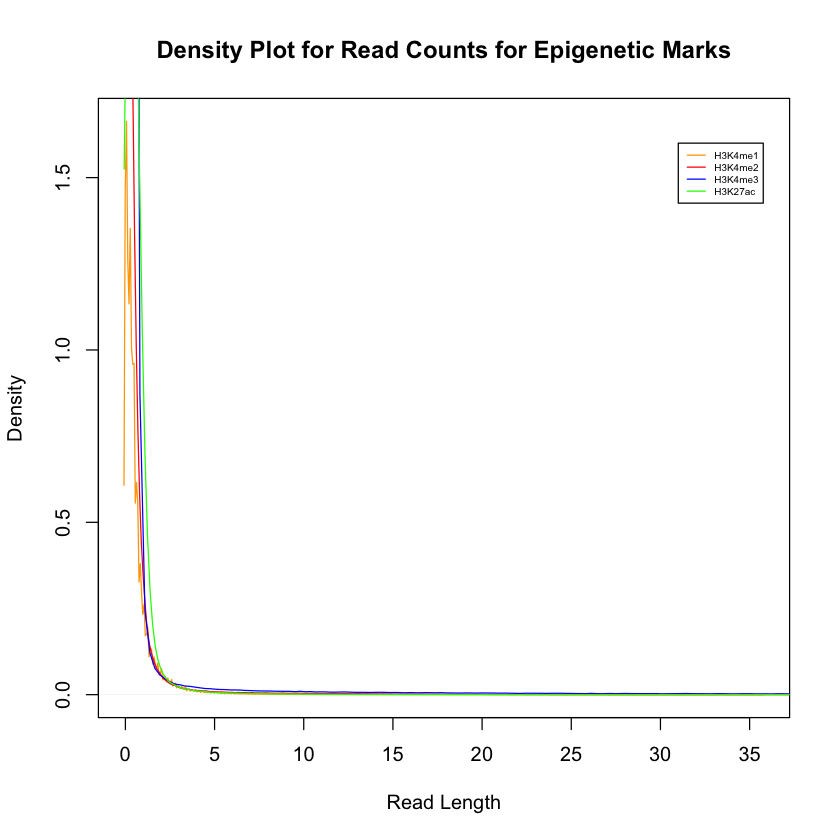

In [7]:
## Density Plots

plot(density(countMatrix$H3K4me1), col="orange", xlab = "Read Length", ylab = "Density", main = "Density Plot for Read Counts for Epigenetic Marks")
lines(density(countMatrix$H3K4me2), col="red")
lines(density(countMatrix$H3K4me3), col="blue")
lines(density(countMatrix$H3K27ac), col="green")
legend(31, 1.6, legend=c("H3K4me1", "H3K4me2", "H3K4me3", "H3K27ac"),
       col=c("orange", "red", "blue", "green"), lty=1, cex= 0.5)

We also decipher that the average read length is about 36. The above graphic illustrates that shorter reads have greater alignment scores than lengthier ones.

## computeMatrix and plotProfile functions: visualization of peaks

In [11]:
## Let's isolate the individual score columns into distinct files to be fed to computeMatrix.

for (co in 4:7)
{
  write.table(countMatrix[,c(1:3,co)], 
              file = paste0(as.character(co), "th_mark.bedGraph"), 
              sep = "\t",
              quote = FALSE,
              row.names = FALSE,
              col.names = c("chrom", "start", "end", "score"))
}

Since computeMatrix algorithm takes bigWig files as input, we shall first convert our bedGraph files to bigWig files. For doing so, we shall download and install *bedGraphToBigWig* and *bedClip* tools from **http://genome.ucsc.edu**, and chromosome sizes for hg19. Remember to make the tools executable.

In [12]:
## Change to the working directory
## Make tools executable

system ("chmod a+x ./bedGraphToBigWig")
system ("chmod a+x ./bedClip")


## Remove headers from the files

system("awk '{if (NR!=1) {print}}' 4th_mark.bedGraph > 4th_mark_noHeader.bedGraph")
system("awk '{if (NR!=1) {print}}' 5th_mark.bedGraph > 5th_mark_noHeader.bedGraph")
system("awk '{if (NR!=1) {print}}' 6th_mark.bedGraph > 6th_mark_noHeader.bedGraph")
system("awk '{if (NR!=1) {print}}' 7th_mark.bedGraph > 7th_mark_noHeader.bedGraph")

## Trim the extremities for genomic coordinates to be contained inside the defined chromosome sizes 
## for the given version of human genome (hg19 here).

system("./bedClip 4th_mark_noHeader.bedGraph hg19.chrom.sizes 4th_mark_noHeader_clipped.bedGraph")
system("./bedClip 5th_mark_noHeader.bedGraph hg19.chrom.sizes 5th_mark_noHeader_clipped.bedGraph")
system("./bedClip 6th_mark_noHeader.bedGraph hg19.chrom.sizes 6th_mark_noHeader_clipped.bedGraph")
system("./bedClip 7th_mark_noHeader.bedGraph hg19.chrom.sizes 7th_mark_noHeader_clipped.bedGraph")

## Sort our bedGraph files

system ("sort -k1,1 -k2,2n  4th_mark_noHeader_clipped.bedGraph > 4th_mark_noHeader_clipped_sorted.bedGraph")
system ("sort -k1,1 -k2,2n  5th_mark_noHeader_clipped.bedGraph > 5th_mark_noHeader_clipped_sorted.bedGraph")
system ("sort -k1,1 -k2,2n  6th_mark_noHeader_clipped.bedGraph > 6th_mark_noHeader_clipped_sorted.bedGraph")
system ("sort -k1,1 -k2,2n  7th_mark_noHeader_clipped.bedGraph > 7th_mark_noHeader_clipped_sorted.bedGraph")

## Converting to bigWig format

system("./bedGraphToBigWig 4th_mark_noHeader_clipped_sorted.bedGraph hg19.chrom.sizes 4th_mark.bw")
system("./bedGraphToBigWig 5th_mark_noHeader_clipped_sorted.bedGraph hg19.chrom.sizes 5th_mark.bw")
system("./bedGraphToBigWig 6th_mark_noHeader_clipped_sorted.bedGraph hg19.chrom.sizes 6th_mark.bw")
system("./bedGraphToBigWig 7th_mark_noHeader_clipped_sorted.bedGraph hg19.chrom.sizes 7th_mark.bw")

In [ ]:
## Executing computeMatrix

system("bash computeMatrixRun.sh")

In [1]:
sessionInfo()

R version 3.3.3 (2017-03-06)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X Yosemite 10.10.5

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_3.3.3     htmltools_0.4.0
 [5] pillar_1.4.3    base64enc_0.1-3 crayon_1.3.4    Rcpp_1.0.3     
 [9] uuid_0.1-4      IRkernel_1.1    jsonlite_1.6.1  digest_0.6.25  
[13] repr_1.1.0      rlang_0.4.4     evaluate_0.14  

## References

<div class="cite2c-biblio"></div>